In [1]:
# 注 调用RNNCell这个需要循环，循环长度就是序列长度
import torch

batch_size = 1  # 批处理大小
seq_len = 3     # 序列长度
input_size = 4  # 输入维度
hidden_size = 2 # 隐层维度

cell = torch.nn.RNNCell(input_size=input_size, hidden_size=hidden_size)

# (seq, batch, features)
dataset = torch.randn(seq_len, batch_size, input_size)
hidden = torch.zeros(batch_size, hidden_size)

# 这个循环就是处理seq_len长度的数据
for idx, data in enumerate(dataset):
    print('=' * 20, idx, '=' * 20)
    print('Input size:', data.shape, data)

    hidden = cell(data, hidden)

    print('hidden size:', hidden.shape, hidden)
    print(hidden)

==================== 0 ====================
Input size: torch.Size([1, 4]) tensor([[-2.5935, -0.4623,  0.2474,  1.8475]])
hidden size: torch.Size([1, 2]) tensor([[-0.6868, -0.3829]], grad_fn=<TanhBackward>)
tensor([[-0.6868, -0.3829]], grad_fn=<TanhBackward>)
==================== 1 ====================
Input size: torch.Size([1, 4]) tensor([[-0.9006, -1.5897, -0.7521, -0.8903]])
hidden size: torch.Size([1, 2]) tensor([[ 0.9607, -0.7583]], grad_fn=<TanhBackward>)
tensor([[ 0.9607, -0.7583]], grad_fn=<TanhBackward>)
==================== 2 ====================
Input size: torch.Size([1, 4]) tensor([[-0.1715, -0.1162, -0.2700,  0.0835]])
hidden size: torch.Size([1, 2]) tensor([[-0.4698, -0.1793]], grad_fn=<TanhBackward>)
tensor([[-0.4698, -0.1793]], grad_fn=<TanhBackward>)


In [2]:
# RNN

import torch

batch_size = 1
seq_len = 3
input_size = 4
hidden_size = 2
num_layers = 1

cell = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

# (seqLen, batchSize, inputSize)
inputs = torch.randn(seq_len, batch_size, input_size)
hidden = torch.zeros(num_layers, batch_size, hidden_size)

out, hidden = cell(inputs, hidden)

print('Output size:', out.shape)        # (seq_len, batch_size, hidden_size)
print('Output:', out)
print('Hidden size:', hidden.shape)     # (num_layers, batch_size, hidden_size)
print('Hidden:', hidden)

Output size: torch.Size([3, 1, 2])
Output: tensor([[[-0.2217,  0.7189]],

        [[-0.8985,  0.6864]],

        [[-0.6135,  0.9297]]], grad_fn=<StackBackward>)
Hidden size: torch.Size([1, 1, 2])
Hidden: tensor([[[-0.6135,  0.9297]]], grad_fn=<StackBackward>)


In [3]:
# 序列到序列的demo, 使用RNN Cell实现
import torch
input_size = 4
hidden_size = 4
batch_size = 1

idx2char = ['e', 'h', 'l', 'o'] # 字典
x_data = [1, 0, 2, 3, 3]    # hello中各个字符的下标
y_data = [3, 1, 2, 3, 2]    # ohlol中各个字符的下标

one_hot_lookup = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]
x_one_hot = [one_hot_lookup[x] for x in x_data] # (seqLen, inputSize)

inputs = torch.Tensor(x_one_hot).view(-1, batch_size, input_size)
labels = torch.LongTensor(y_data).view(-1, 1)   # torch.Tensor默认是torch.FloatTensor是32位浮点类型数据，torch.LongTensor是64位整型
print(inputs.shape, labels.shape)

# 构建模型
import torch.nn as nn
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size):
        super(Model, self).__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnncell = nn.RNNCell(input_size=self.input_size, hidden_size=self.hidden_size)

    def forward(self, inputs, hidden):
        hidden = self.rnncell(inputs, hidden)   # (batch_size, hidden_size)
        return hidden

    def init_hidden(self):
        return torch.zeros(self.batch_size, self.hidden_size)

net = Model(input_size, hidden_size, batch_size)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

# 训练数据
epochs = 15
for epoch in range(epochs):
    loss = 0
    optimizer.zero_grad()
    hidden = net.init_hidden()
    print('Predicted string:', end='')
    for input, label in zip(inputs, labels):
        hidden = net(input, hidden)
        # 注意交叉熵在计算loss的时候维度关系，这里的hidden是([1, 4]), label是 ([1])
        loss += criterion(hidden, label)
        _, idx = hidden.max(dim = 1)
        print(idx2char[idx.item()], end='')
    loss.backward()
    optimizer.step()
    print(', Epoch [%d/15] loss=%.4f' % (epoch+1, loss.item()))

torch.Size([5, 1, 4]) torch.Size([5, 1])
Predicted string:leloo, Epoch [1/15] loss=6.5516
Predicted string:lhloo, Epoch [2/15] loss=5.2902
Predicted string:lhloo, Epoch [3/15] loss=4.6566
Predicted string:lhloo, Epoch [4/15] loss=4.2846
Predicted string:ohloo, Epoch [5/15] loss=4.0401
Predicted string:ohlol, Epoch [6/15] loss=3.8526
Predicted string:ohlol, Epoch [7/15] loss=3.6770
Predicted string:ohlol, Epoch [8/15] loss=3.4852
Predicted string:ohlol, Epoch [9/15] loss=3.2798
Predicted string:ohlol, Epoch [10/15] loss=3.0964
Predicted string:ohlol, Epoch [11/15] loss=2.9560
Predicted string:ohlol, Epoch [12/15] loss=2.8546
Predicted string:ohlol, Epoch [13/15] loss=2.7766
Predicted string:ohlol, Epoch [14/15] loss=2.6903
Predicted string:ohlol, Epoch [15/15] loss=2.5741


In [4]:
## 4.2、RNN实现

# **注意：**
#
# inputs和labels的维度
# inputs维度是: (seqLen, batch_size, input_size)
# labels维度是: (seqLen * batch_size)
# 注意outputs维度，对应和labels做交叉熵的维度
# outputs维度是: (seqLen, batch_size, hidden_size)
# 为了能和labels做交叉熵，需要reshape一下: outputs.view(-1, hidden_size)
# 数据准备

import torch
input_size = 4
hidden_size = 4
batch_size = 1
seq_len = 5
num_layers = 1

idx2char = ['e', 'h', 'l', 'o']
x_data = [1, 0, 2, 3, 3]    # hello中各个字符的下标
y_data = [3, 1, 2, 3, 2]    # ohlol中各个字符的下标

one_hot_lookup = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]
x_one_hot = [one_hot_lookup[x] for x in x_data] # (seqLen, inputSize)

inputs = torch.Tensor(x_one_hot).view(seq_len, batch_size, input_size)
labels = torch.LongTensor(y_data)
print(inputs.shape, labels.shape)


# 构建模型
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, num_layers=1):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, )

    def forward(self, inputs):
        hidden = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        out, _ = self.rnn(inputs, hidden)    # 注意维度是(seqLen, batch_size, hidden_size)
        return out.view(-1, self.hidden_size) # 为了容易计算交叉熵这里调整维度为(seqLen * batch_size, hidden_size)

net = Model(input_size, hidden_size, batch_size)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)


# 模型训练
epochs = 15
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(inputs)
    # print(outputs.shape, labels.shape)
    # 这里的outputs维度是([seqLen * batch_size, hidden]), labels维度是([seqLen])
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, idx = outputs.max(dim=1)
    idx = idx.data.numpy()
    print('Predicted: ', ''.join([idx2char[x] for x in idx]), end='')
    print(', Epoch [%d/15] loss = %.3f' % (epoch + 1, loss.item()))

torch.Size([5, 1, 4]) torch.Size([5])
Predicted:  lllll, Epoch [1/15] loss = 1.308
Predicted:  lllll, Epoch [2/15] loss = 1.102
Predicted:  ohool, Epoch [3/15] loss = 0.968
Predicted:  ohooo, Epoch [4/15] loss = 0.908
Predicted:  ohooo, Epoch [5/15] loss = 0.846
Predicted:  ohool, Epoch [6/15] loss = 0.779
Predicted:  ohlol, Epoch [7/15] loss = 0.724
Predicted:  ohlol, Epoch [8/15] loss = 0.683
Predicted:  ohlol, Epoch [9/15] loss = 0.648
Predicted:  ohlol, Epoch [10/15] loss = 0.616
Predicted:  ohlol, Epoch [11/15] loss = 0.588
Predicted:  ohlol, Epoch [12/15] loss = 0.565
Predicted:  ohlol, Epoch [13/15] loss = 0.547
Predicted:  ohlol, Epoch [14/15] loss = 0.532
Predicted:  ohlol, Epoch [15/15] loss = 0.516


In [5]:
# 词向量方式

# 数据准备
idx2char = ['e', 'h', 'l', 'o']
x_data = [[1, 0, 2, 2, 3]]  # (batch, seq_len)
y_data = [3, 1, 2, 3, 2]    # (batch * seq_len)

inputs = torch.LongTensor(x_data)   # Input should be LongTensor: (batchSize, seqLen)
labels = torch.LongTensor(y_data)   # Target should be LongTensor: (batchSize * seqLen)


# 构建模型
import torch.nn as nn

# parameters
num_class = 4
input_size = 4
hidden_size = 8
embedding_size = 10
num_layers = 2
batch_size = 1
seq_len = 5

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.emb = torch.nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, x):
        hidden = torch.zeros(num_layers, x.size(0), hidden_size)
        x = self.emb(x)                 # (batch, seqLen, embeddingSize)
        x, _ = self.rnn(x, hidden)      # 输出(𝒃𝒂𝒕𝒄𝒉𝑺𝒊𝒛𝒆, 𝒔𝒆𝒒𝑳𝒆𝒏, hidden_size)
        x = self.fc(x)                  # 输出(𝒃𝒂𝒕𝒄𝒉𝑺𝒊𝒛𝒆, 𝒔𝒆𝒒𝑳𝒆𝒏, 𝒏𝒖𝒎𝑪𝒍𝒂𝒔𝒔)
        return x.view(-1, num_class)    # reshape to use Cross Entropy: (𝒃𝒂𝒕𝒄𝒉𝑺𝒊𝒛𝒆×𝒔𝒆𝒒𝑳𝒆𝒏, 𝒏𝒖𝒎𝑪𝒍𝒂𝒔𝒔)

net = Model()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)


# 模型训练
epochs = 15
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, idx = outputs.max(dim=1)
    idx = idx.data.numpy()
    print('Predicted: ', ''.join([idx2char[x] for x in idx]), end='')
    print(', Epoch [%d/15] loss = %.3f' % (epoch + 1, loss.item()))

Predicted:  hooeh, Epoch [1/15] loss = 1.435
Predicted:  ohool, Epoch [2/15] loss = 1.102
Predicted:  lhool, Epoch [3/15] loss = 0.905
Predicted:  lhlol, Epoch [4/15] loss = 0.757
Predicted:  lhlol, Epoch [5/15] loss = 0.649
Predicted:  lhlol, Epoch [6/15] loss = 0.575
Predicted:  lhlol, Epoch [7/15] loss = 0.510
Predicted:  ohlol, Epoch [8/15] loss = 0.443
Predicted:  ohlol, Epoch [9/15] loss = 0.375
Predicted:  ohlol, Epoch [10/15] loss = 0.311
Predicted:  ohlol, Epoch [11/15] loss = 0.255
Predicted:  ohlol, Epoch [12/15] loss = 0.207
Predicted:  ohlol, Epoch [13/15] loss = 0.168
Predicted:  ohlol, Epoch [14/15] loss = 0.137
Predicted:  ohlol, Epoch [15/15] loss = 0.113


In [12]:
# GRU 分类模型

# 准备数据
# 1、对于每个名字需要得到一个向量
# 2、通过ASCII对于每个名字的每个字符都得到一个one-hot vector
# 3、由于输入是矩阵所以需要padding
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gzip
import csv

class NameDataset(Dataset):
    def __init__(self, is_train_set):
        filename = '../dataset/names_train.csv' if is_train_set else '../dataset/names_test.csv'
        with open(filename, 'rt') as f:    # r表示只读，从文件头开始 t表示文本模式
            reader = csv.reader(f)
            rows = list(reader)
        self.names = [row[0] for row in rows]
        self.len = len(self.names)
        self.countries = [row[1] for row in rows]

        self.country_list = list(sorted(set(self.countries)))
        self.country_dict = self.getCountryDict()
        self.country_num = len(self.country_list)

    def __getitem__(self, index):       # 根据索引拿到的是 名字，国家的索引
        return self.names[index], self.country_dict[self.countries[index]]

    def __len__(self):
        return self.len

    def getCountryDict(self):
        country_dict = dict()
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx
        return country_dict

    def idx2country(self, index):
        return self.country_list[index]

    def getCountriesNum(self):
        return self.country_num

HIDDEN_SIZE = 100
BATCH_SIZE = 256
N_LAYER = 2
N_EPOCHS = 50
N_CHARS = 128   # 这个是为了构造嵌入层

trainSet = NameDataset(is_train_set=True)
trainLoader = DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=True)
testSet = NameDataset(is_train_set=False)
testLoader = DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False)

N_COUNTRY = trainSet.getCountriesNum()

In [13]:
# 构建模型
# GRU的维度
# 输入维度：
# 𝑖𝑛𝑝𝑢𝑡: (𝑠𝑒𝑞𝐿𝑒𝑛, 𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒, ℎ𝑖𝑑𝑑𝑒𝑛𝑆𝑖𝑧𝑒)
# hidden: (nLayers * nDirections, batchSize, hiddenSize)
# 输出维度
# output: (seqLen, batchSize, hiddenSize * nDirections)
# hidden: (nLayers * nDirections, batchSize, hiddenSize)

class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1   # 使用双向的GRU

        # 嵌入层（𝑠𝑒𝑞𝐿𝑒𝑛, 𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒） --> (𝑠𝑒𝑞𝐿𝑒𝑛, 𝑏𝑎𝑡𝑐ℎ𝑆𝑖𝑧𝑒, hidden_size)
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size)
        return hidden

    def forward(self, input, seq_lengths):
        # input shape : B x S -> S x B
        input = input.t()
        batch_size = input.size(1)
        hidden = self._init_hidden(batch_size)
        embedding = self.embedding(input)

        # pack them up
        gru_input = torch.nn.utils.rnn.pack_padded_sequence(embedding, seq_lengths)
        output, hidden = self.gru(gru_input, hidden)
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        fc_output = self.fc(hidden_cat)
        return fc_output

In [19]:
# 数据转换成Tensor
def name2list(name):
    arr = [ord(c) for c in name]
    return arr, len(arr)

def make_tensors(names, countries):
    sequences_and_lengths = [name2list(name) for name in names]
    name_sequences = [s1[0] for s1 in sequences_and_lengths]
    seq_lengths = torch.LongTensor([s1[1] for s1 in sequences_and_lengths])
    countries = countries.long()

    # make tensor of name, BatchSize * seqLen
    # 他这里补零的方式先将所有的0 Tensor给初始化出来，然后在每行前面填充每个名字
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long()
    # print("seq_lengths.max:", seq_lengths.max())
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # sort by length to use pack_padded_sequence
    # 将名字长度降序排列，并且返回降序之后的长度在原tensor中的小标perm_idx
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    # 这个Tensor中的类似于列表中切片的方法神奇啊，直接返回下标对应的元素，相等于排序了
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]

    # 返回排序之后名字Tensor，排序之后的名字长度Tensor，排序之后的国家名字Tensor
    return seq_tensor, seq_lengths, countries

True
Training for 50 epochs...
 3s] Epoch 1 [2560/13374] loss=0.008832729514688253
 5s] Epoch 1 [5120/13374] loss=0.007542191515676677
 7s] Epoch 1 [7680/13374] loss=0.006860072553778688
 10s] Epoch 1 [10240/13374] loss=0.006449167791288346
 13s] Epoch 1 [12800/13374] loss=0.00606359270401299
evaluating trained model ... 
Test set: Accuracy 4486/6700 66.96%
 17s] Epoch 2 [2560/13374] loss=0.004324496164917946
 20s] Epoch 2 [5120/13374] loss=0.004129905730951578
 22s] Epoch 2 [7680/13374] loss=0.003995212229589621
 24s] Epoch 2 [10240/13374] loss=0.003893147746566683
 27s] Epoch 2 [12800/13374] loss=0.003799401265569031
evaluating trained model ... 
Test set: Accuracy 4964/6700 74.09%
 31s] Epoch 3 [2560/13374] loss=0.00313174978364259
 33s] Epoch 3 [5120/13374] loss=0.0031205926090478895
 35s] Epoch 3 [7680/13374] loss=0.003105234323690335
 38s] Epoch 3 [10240/13374] loss=0.0030474235361907633
 40s] Epoch 3 [12800/13374] loss=0.003038507895544171
evaluating trained model ... 
Test set:

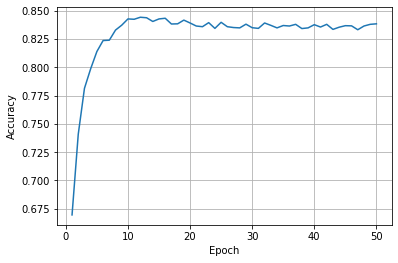

In [24]:
# 训练模型
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRY, N_LAYER)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

import time
import math

def trainModel():
    def time_since(since):
        s = time.time() - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    total_loss = 0
    for i, (names, countries) in enumerate(trainLoader, 1):
        # print(type(names), type(countries))
        # print(len(names), countries.shape)
        inputs, seq_lengths, target = make_tensors(names, countries)
        inputs = inputs
        seq_lengths = seq_lengths
        target = target
        output = classifier(inputs, seq_lengths)
        # print("Shape:", output.shape, target.shape)
        # 注意输出和目标的维度：Shape: torch.Size([256, 18]) torch.Size([256])
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i % 10 == 0:
            print(f'[{time_since(start)}] Epoch {epoch} ', end='')
            print(f'[{i * len(inputs)}/{len(trainSet)}] ', end='')
            print(f'loss={total_loss / (i * len(inputs))}')
    return total_loss

def testModel():
    correct = 0
    total = len(testSet)
    print("evaluating trained model ... ")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testLoader):
            inputs, seq_lengths, target = make_tensors(names, countries)
            inputs = inputs
            seq_lengths = seq_lengths
            target = target
            output = classifier(inputs, seq_lengths)
            # 注意这个keepdim的使用，为了直接和target计算loss
            pred = output.max(dim=1, keepdim=True)[1]
            # 注意这个view_as 和 eq
            correct += pred.eq(target.view_as(pred)).sum().item()

        percent = '%.2f' % (100 * correct / total)
        print(f'Test set: Accuracy {correct}/{total} {percent}%')

    return correct / total

N_EPOCHS = 50
start = time.time()
print("Training for %d epochs..." % N_EPOCHS)
acc_list = []
for epoch in range(1, N_EPOCHS + 1):
    # Train cycle
    total_loss = trainModel()
    acc = testModel()
    acc_list.append(acc)


# 可视化
import matplotlib.pyplot as plt
import numpy as np

epoch = np.arange(1, len(acc_list) + 1)
acc_list = np.array(acc_list)
plt.plot(epoch, acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()